In [ ]:
#| hide

%set_env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [ ]:
#| default_exp models.vcformer

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

# VCFormer

VCformer stands for Variable Correlation Transformer and implement the variable correlation attention mechanism to learn correlations between variates. It also implements a Koopman Temporal Detector (KTD) to better address non-stationarity in time series.

**References**
- [Yingnan Yang, Qingling Zhu, Jianyong Chen. "VCformer: Variable Correlation Transformer with Inherent Lagged Correlation for Multivariate Time Series Forecasting"](https://arxiv.org/abs/2405.11470)

![Figure 1. Architecture of iTransformer.](imgs_models/vcformer.png)

In [ ]:
#| export

import torch
import torch.nn as nn
import torch.nn.functional as F

from math import sqrt

from einops import rearrange

from neuralforecast.common._modules import MLP, TransEncoder

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_multivariate import BaseMultivariate

# 1. Auxiliary functions
## 1.1 Embedding 

In [ ]:
#| exporti

class DataEmbedding_inverted(nn.Module):
    def __init__(self, c_in, d_model, dropout=0.1):
        super(DataEmbedding_inverted, self).__init__()
        self.value_embedding = nn.Linear(c_in, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = x.permute(0, 2, 1)
        # x: [Batch Variate Time]
        if x_mark is None:
            # if not time feature
            x = self.value_embedding(x)
        else:
            # if have time feature
            x = self.value_embedding(
                torch.cat([x, x_mark.permute(0, 2, 1)], 1))
        # x: [Batch Variate d_model]
        return self.dropout(x)

## 1.2 KTD

In [ ]:
#| exporti

class KPLayerApprox(nn.Module):
    def __init__(self):
        super(KPLayerApprox, self).__init__()
        self.K = None
        self.K_step = None

    def forward(self, z):
        B, N, input_len, hidden_dim = z.shape
        pred_len = input_len
        z = rearrange(z, 'b n pn m -> (b n) pn m')
        x, y = z[:, :-1], z[:, 1:]

        self.K = torch.linalg.lstsq(x, y).solution

        if torch.isnan(self.K).any():
            print('Encounter K with nan, replace K by identity matrix')
            self.K = torch.eye(self.K.shape[1]).to(
                self.K.device).unsqueeze(0).repeat(B, 1, 1)

        self.K_step = torch.linalg.matrix_power(self.K, pred_len)
        if torch.isnan(self.K_step).any():
            print('Encounter multistep K with nan, replace it by identity matrix')
            self.K_step = torch.eye(self.K_step.shape[1]).to(
                self.K_step.device).unsqueeze(0).repeat(B, 1, 1)
        z_pred = torch.bmm(z[:, -pred_len:, :], self.K_step)
        return z_pred


class KTDlayer(nn.Module):
    """
        Koopman Temporal Detector layer
    """

    def __init__(self, enc_in, snap_size, proj_dim, hidden_dim, hidden_layers):
        super(KTDlayer, self).__init__()
        self.enc_in = enc_in
        self.snap_size = snap_size
        self.dynamics = KPLayerApprox()
        self.encoder = MLP(in_features=snap_size, out_features=proj_dim, activation='Tanh', hidden_size=hidden_dim, num_layers=hidden_layers, dropout=0.05)
        self.decoder = MLP(in_features=proj_dim, out_features=snap_size, activation='Tanh', hidden_size=hidden_dim, num_layers=hidden_layers, dropout=0.05)
        self.padding_len = snap_size - \
            (enc_in % snap_size) if enc_in % snap_size != 0 else 0

    def forward(self, x):
        # x: B L D
        B, N, D = x.shape

        res = torch.cat((x[:, :, D-self.padding_len:], x), dim=-1)

        res = rearrange(res, 'b n (p_n p) -> b n p_n p', p=self.snap_size)

        res = self.encoder(res)  # b n p_n m, m means hidden dim

        # b*n f_n m, f_n means forecast patch num
        x_pred = self.dynamics(res)

        x_pred = self.decoder(x_pred)     # b*n f_n p

        x_pred = rearrange(x_pred, '(b n) f_n p -> b n (f_n p)', b=B)

        return x_pred

## 1.3 Encoder layer

In [ ]:
#| exporti

class EncoderLayer(nn.Module):
    def __init__(self, attention, ktd, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.ktd = ktd
        self.lin1 = nn.Linear(d_model, d_ff)
        self.lin2 = nn.Linear(d_ff, d_model)
        self.conv1 = nn.Conv1d(in_channels=d_model,
                               out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(
            in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        # VCA module
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask,
            tau=tau, delta=delta
        )
        x = x + self.dropout(new_x)
        y = x = self.norm1(x)

        # KTD Module
        x_ktd = y
        y = self.dropout(self.ktd(x_ktd))

        return self.norm2(x_ktd + y), attn

## 1.4 Attention

In [ ]:
#| exporti

class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask

class VarCorAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False) -> None:
        super(VarCorAttention, self).__init__()

        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def origin_compute_cross_cor(self, queries, keys):
        q_fft = torch.fft.rfft(queries, dim=-1)
        k_fft = torch.fft.rfft(keys, dim=-1)

        res = q_fft*k_fft
        corr = torch.fft.irfft(res, dim=-1)
        corr = corr.mean(dim=-1)
        return corr

    def compute_cross_cor(self, queries, keys):

        q_fft = torch.fft.rfft(queries, dim=-1)
        k_fft = torch.fft.rfft(keys, dim=-1)
        q_fft = q_fft.unsqueeze(1)  # [D,1,T/2+1]
        k_fft = torch.conj(k_fft.unsqueeze(0))  # [1,D,T/2+1]
        res = q_fft*k_fft  # [D,D,T/2+1]
        corr = torch.fft.irfft(res, dim=-1)
        corr = corr.mean(dim=-1)

        return corr

    def optimized_compute_cross_cor(self, queries, keys):
        # Perform batched FFT
        q_fft = torch.fft.rfft(queries, dim=-1)
        k_fft = torch.fft.rfft(keys, dim=-1)

        # Expand dimensions for broadcasting
        q_fft = q_fft.unsqueeze(2)  # [B, D, 1, T/2+1]
        k_fft = torch.conj(k_fft.unsqueeze(1))  # [B, 1, D, T/2+1]

        # Element-wise multiplication and batched inverse FFT
        res = q_fft * k_fft  # [B, D, D, T/2+1]
        corr = torch.fft.irfft(res, dim=-1)

        # Mean across the time dimension
        corr = corr.mean(dim=-1)

        return corr

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):

        B, D, T = queries.shape
        _, S, _ = values.shape
        corr = torch.zeros(B, D, D).to(queries.device)
        scale = self.scale or 1./sqrt(T)

        for i in range(B):
            for j in range(D):
                corr[[i], [j], :] = self.origin_compute_cross_cor(
                    queries[[i], [j], :], keys[[i], :, :])

        for i in range(B):
            corr[[i], :, :] = self.compute_cross_cor(
                queries[[i], :, :], keys[[i], :, :])

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, T, device=queries.device)
        corr = torch.softmax(corr*scale, dim=-1)

        V = torch.einsum("bsd,bde->bse", corr, values)
        if self.output_attention:
            return (V.contiguous(), corr)
        else:
            return (V.contiguous(), None)
        
class VarCorAttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(VarCorAttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, D, L = queries.shape
        _, _, S = keys.shape

        queries = self.query_projection(queries)
        keys = self.key_projection(keys)
        values = self.value_projection(values)
        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask,
            tau=tau,
            delta=delta
        )
        out = out.view(B, D, -1)

        return self.out_projection(out), attn

# 2. VCformer

In [ ]:
#| export

class VCformer(BaseMultivariate):

    """ VCformer
    
    **Parameters:**<br>
    `h`: int, Forecast horizon. <br>
    `input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
    `n_series`: int, number of time-series.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `hidden_size`: int, dimension of the model.<br>
    `n_heads`: int, number of heads.<br>
    `e_layers`: int, number of encoder layers.<br>
    `d_ff`: int, dimension of fully-connected layer.<br>
    `snap_size`: int, snapshot size for Koopman Temporal Detector<br>
    `projection_dim`: int, projection dimension of Koopman space<br>
    `hidden_enc_dim`: int, hidden dimension of Koopman encoder<br>
    `hidden_ktd_layers`: number of hidden layers of Koopman Temporal Detector<br>
    `factor`: int, attention factor.<br>
    `dropout`: float, dropout rate.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
    `lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>
    **References**
    - [Yingnan Yang, Qingling Zhu, Jianyong Chen. "VCformer: Variable Correlation Transformer with Inherent Lagged Correlation for Multivariate Time Series Forecasting"](https://arxiv.org/abs/2405.11470)
    """

    # Class attributes
    SAMPLING_TYPE = 'multivariate'
    EXOGENOUS_FUTR = False
    EXOGENOUS_HIST = False
    EXOGENOUS_STAT = False

    def __init__(self,
                 h,
                 input_size,
                 n_series,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 #VCformer
                 hidden_size: int = 512,
                 n_heads: int = 8,
                 e_layers: int = 2,
                 d_ff: int = 2048,
                 snap_size: int = 16,
                 projection_dim: int = 128,
                 hidden_enc_dim: int = 256,
                 hidden_ktd_layers: int = 1,
                 factor: int = 1,
                 dropout: float = 0.1,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 lr_scheduler = None,
                 lr_scheduler_kwargs = None,            
                 **trainer_kwargs):
        
        super(VCformer, self).__init__(h=h,
                                       input_size=input_size,
                                       n_series=n_series,
                                       stat_exog_list = None,
                                       futr_exog_list = None,
                                       hist_exog_list = None,
                                       loss=loss,
                                       valid_loss=valid_loss,
                                       max_steps=max_steps,
                                       learning_rate=learning_rate,
                                       num_lr_decays=num_lr_decays,
                                       early_stop_patience_steps=early_stop_patience_steps,
                                       val_check_steps=val_check_steps,
                                       batch_size=batch_size,
                                       step_size=step_size,
                                       scaler_type=scaler_type,
                                       random_seed=random_seed,
                                       num_workers_loader=num_workers_loader,
                                       drop_last_loader=drop_last_loader,
                                       optimizer=optimizer,
                                       optimizer_kwargs=optimizer_kwargs,
                                       lr_scheduler=lr_scheduler,
                                       lr_scheduler_kwargs=lr_scheduler_kwargs,
                                       **trainer_kwargs)
        
        self.h = h
        self.enc_in = n_series
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.factor = factor
        self.n_heads = n_heads
        self.snap_size = snap_size
        self.projection_dim = projection_dim
        self.hidden_enc_dim = hidden_enc_dim
        self.hidden_ktd_layers = hidden_ktd_layers
        self.d_ff = d_ff
        self.e_layers = e_layers

        # Architecture
        self.enc_embedding = DataEmbedding_inverted(input_size, hidden_size, self.dropout)

        self.encoder = TransEncoder(
            [
                EncoderLayer(
                    VarCorAttentionLayer(
                        VarCorAttention(factor=self.factor, attention_dropout=self.dropout),
                        self.hidden_size,
                        self.n_heads
                    ),
                    KTDlayer(self.hidden_size, self.snap_size, self.projection_dim, self.hidden_enc_dim, self.hidden_ktd_layers),
                    self.hidden_size,
                    self.d_ff,
                    self.dropout,
                    activation=F.gelu
                ) for l in range(self.e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(self.hidden_size)
        )

        self.projection = nn.Linear(self.hidden_size, h, bias=True)

    def forecast(self, x_enc, x_mark_enc=None):
        # Normalization from Non-stationary Transformer
        means = x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc - means
        stdev = torch.sqrt(
            torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
        x_enc /= stdev

        _, _, N = x_enc.shape

        # Embedding
        enc_out = self.enc_embedding(x_enc, x_mark_enc)

        enc_out, attns = self.encoder(enc_out, attn_mask=None)
        # reshape enc_out[B,D,T] -> dec_out[B,T,D]
        dec_out = self.projection(enc_out).permute(0, 2, 1)[:, :, :N]
        # De-Normalization from Non-stationary Transformer
        dec_out = dec_out * \
            (stdev[:, 0, :].unsqueeze(1).repeat(1, self.h, 1))
        dec_out = dec_out + \
            (means[:, 0, :].unsqueeze(1).repeat(1, self.h, 1))
        return dec_out
    
    def forward(self, windows_batch):
        insample_y = windows_batch['insample_y']

        y_pred = self.forecast(insample_y)
        y_pred = y_pred[:, -self.h:, :]
        y_pred = self.loss.domain_map(y_pred)

        # domain_map might have squeezed the last dimension in case n_series == 1
        if y_pred.ndim == 2:
            return y_pred.unsqueeze(-1)
        else:
            return y_pred

In [ ]:
show_doc(VCformer)

---

### VCformer

>      VCformer (h, input_size, n_series, futr_exog_list=None,
>                hist_exog_list=None, stat_exog_list=None, hidden_size:int=512,
>                n_heads:int=8, e_layers:int=2, d_ff:int=2048, snap_size:int=16,
>                projection_dim:int=128, hidden_enc_dim:int=256,
>                hidden_ktd_layers:int=1, factor:int=1, dropout:float=0.1,
>                loss=MAE(), valid_loss=None, max_steps:int=1000,
>                learning_rate:float=0.001, num_lr_decays:int=-1,
>                early_stop_patience_steps:int=-1, val_check_steps:int=100,
>                batch_size:int=32, step_size:int=1, scaler_type:str='identity',
>                random_seed:int=1, num_workers_loader:int=0,
>                drop_last_loader:bool=False, optimizer=None,
>                optimizer_kwargs=None, lr_scheduler=None,
>                lr_scheduler_kwargs=None, **trainer_kwargs)

VCformer

**Parameters:**<br>
`h`: int, Forecast horizon. <br>
`input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
`n_series`: int, number of time-series.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`hidden_size`: int, dimension of the model.<br>
`n_heads`: int, number of heads.<br>
`e_layers`: int, number of encoder layers.<br>
`d_ff`: int, dimension of fully-connected layer.<br>
`snap_size`: int, snapshot size for Koopman Temporal Detector<br>
`projection_dim`: int, projection dimension of Koopman space<br>
`hidden_enc_dim`: int, hidden dimension of Koopman encoder<br>
`hidden_ktd_layers`: number of hidden layers of Koopman Temporal Detector<br>
`factor`: int, attention factor.<br>
`dropout`: float, dropout rate.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of different series in each batch.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
`optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
`lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
`lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>
**References**
- [Yingnan Yang, Qingling Zhu, Jianyong Chen. "VCformer: Variable Correlation Transformer with Inherent Lagged Correlation for Multivariate Time Series Forecasting"](https://arxiv.org/abs/2405.11470)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| h |  |  |  |
| input_size |  |  |  |
| n_series |  |  |  |
| futr_exog_list | NoneType | None |  |
| hist_exog_list | NoneType | None |  |
| stat_exog_list | NoneType | None |  |
| hidden_size | int | 512 | VCformer |
| n_heads | int | 8 |  |
| e_layers | int | 2 |  |
| d_ff | int | 2048 |  |
| snap_size | int | 16 |  |
| projection_dim | int | 128 |  |
| hidden_enc_dim | int | 256 |  |
| hidden_ktd_layers | int | 1 |  |
| factor | int | 1 |  |
| dropout | float | 0.1 |  |
| loss | MAE | MAE() |  |
| valid_loss | NoneType | None |  |
| max_steps | int | 1000 |  |
| learning_rate | float | 0.001 |  |
| num_lr_decays | int | -1 |  |
| early_stop_patience_steps | int | -1 |  |
| val_check_steps | int | 100 |  |
| batch_size | int | 32 |  |
| step_size | int | 1 |  |
| scaler_type | str | identity |  |
| random_seed | int | 1 |  |
| num_workers_loader | int | 0 |  |
| drop_last_loader | bool | False |  |
| optimizer | NoneType | None |  |
| optimizer_kwargs | NoneType | None |  |
| lr_scheduler | NoneType | None |  |
| lr_scheduler_kwargs | NoneType | None |  |
| trainer_kwargs |  |  |  |

In [ ]:
show_doc(VCformer.fit, name='VCformer.fit')

---

### VCformer.fit

>      VCformer.fit (dataset, val_size=0, test_size=0, random_seed=None,
>                    distributed_config=None)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [ ]:
show_doc(VCformer.predict, name='VCformer.predict')

---

### VCformer.predict

>      VCformer.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                        **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

# 3. Usage example

In [ ]:
#| eval: false

import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.losses.pytorch import MSE

In [ ]:
#| eval: false

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = VCformer(h=12,
                 input_size=24,
                 n_series=2,
                 hidden_size=128,
                 n_heads=2,
                 e_layers=2,
                 d_ff=4,
                 snap_size=8,
                 projection_dim=64,
                 hidden_enc_dim=64,
                 hidden_ktd_layers=1,
                 factor=1,
                 dropout=0.1,
                 loss=MSE(),
                 valid_loss=MAE(),
                 early_stop_patience_steps=3,
                 batch_size=8,
                 accelerator='cpu')

fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

Seed set to 1
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params
---------------------------------------------------------
0 | loss          | MSE                    | 0     
1 | valid_loss    | MAE                    | 0     
2 | padder        | ConstantPad1d          | 0     
3 | scaler        | TemporalNorm           | 0     
4 | enc_embedding | DataEmbedding_inverted | 3.2 K 
5 | encoder       | TransEncoder           | 157 K 
6 | projection    | Linear                 | 1.5 K 
---------------------------------------------------------
162 K     Trainable params
0         Non-trainable params
162 K     Total params
0.648     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/neuralforecast/core.py:201: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


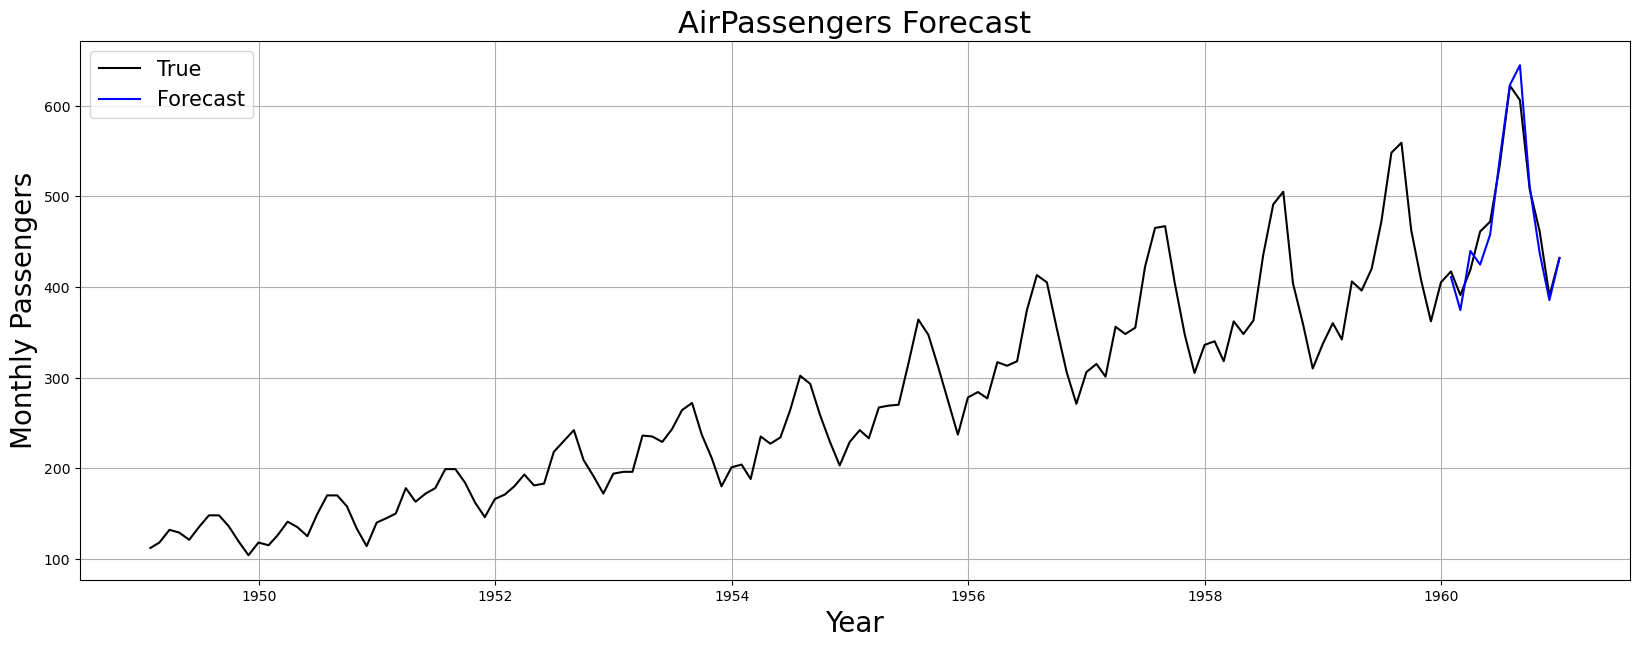

In [ ]:
#| eval: false
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['VCformer'], c='blue', label='Forecast')
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Year', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()